In [1]:
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D
from palettable.tableau import Tableau_10

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys
sys.path.insert(0, '/home/561/jn8053/~/.local/lib')
from xarrayMannKendall import *

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46527/status,
Dashboard: /proxy/46527/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39897,Workers: 4
Dashboard: /proxy/46527/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:43015,Total threads: 4
Dashboard: /proxy/37823/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:34895,


Load reanalysis and CMIP6 multimodel mean

In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'cmip6', 'reanalysis']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [4]:
uas = {}
vas = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))

In [5]:
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
uas_cmip = {}; vas_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
model_keys = list(uas_cmip.keys())

Calculate trends

In [6]:
uas_trends = {}
vas_trends = {}
for k in keys:
    u = uas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_trends[k] = MK_class.compute()
    uas_trends[k] = uas_trends[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_trends[k] = MK_class.compute()
    vas_trends[k] = vas_trends[k].rename({'x':'lon', 'y':'lat'})

In [7]:
uas_trends_cmip = {}
vas_trends_cmip = {}
for k in model_keys:
    u = uas_cmip[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_trends_cmip[k] = MK_class.compute()
    uas_trends_cmip[k] = uas_trends_cmip[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas_cmip[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_trends_cmip[k] = MK_class.compute()
    vas_trends_cmip[k] = vas_trends_cmip[k].rename({'x':'lon', 'y':'lat'})

Calculate area for weighting

In [8]:
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['erai']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['erai'].isel(time = 0)))
for i in range(len(uas['erai']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['erai']['lat'], 'lon':uas['erai']['lon']})

In [9]:
u_ave = {}
v_ave = {}
for k in keys:
    u_ave[k] = (uas[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))
    v_ave[k] = (vas[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))
for k in model_keys:
    u_ave[k] = (uas_cmip[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))
    v_ave[k] = (vas_cmip[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))

In [10]:
ut_ave = {}
vt_ave = {}
for k in keys:
    ut_ave[k] = (uas_trends[k]['trend']*mask*area).sum('lat')/((area*mask).sum('lat'))
    vt_ave[k] = (vas_trends[k]['trend']*mask*area).sum('lat')/((area*mask).sum('lat'))
for k in model_keys:
    ut_ave[k] = (uas_trends_cmip[k]['trend']*mask*area).sum('lat')/((area*mask).sum('lat'))
    vt_ave[k] = (vas_trends_cmip[k]['trend']*mask*area).sum('lat')/((area*mask).sum('lat'))

In [11]:
u_ave_xarray = u_ave[model_keys[0]]
v_ave_xarray = v_ave[model_keys[0]]
for k in model_keys[1:]:
    u_ave_xarray = xr.concat([u_ave_xarray, u_ave[k]], dim = 'model')
    v_ave_xarray = xr.concat([v_ave_xarray, v_ave[k]], dim = 'model')
u_ave_xarray['model'] = model_keys
v_ave_xarray['model'] = model_keys

u_ave_cmip_sd = u_ave_xarray.sel(model = model_keys).std('model')
v_ave_cmip_sd = v_ave_xarray.sel(model = model_keys).std('model')

In [12]:
ut_ave_xarray = ut_ave[model_keys[0]]
vt_ave_xarray = vt_ave[model_keys[0]]
for k in model_keys[1:]:
    ut_ave_xarray = xr.concat([ut_ave_xarray, ut_ave[k]], dim = 'model')
    vt_ave_xarray = xr.concat([vt_ave_xarray, vt_ave[k]], dim = 'model')
ut_ave_xarray['model'] = model_keys
vt_ave_xarray['model'] = model_keys

ut_ave_cmip_sd = ut_ave_xarray.sel(model = model_keys).std('model')
vt_ave_cmip_sd = vt_ave_xarray.sel(model = model_keys).std('model')

In [15]:
import cmocean

In [24]:
legend_elements = [Line2D([0], [0], color = 'm', lw = 2, label = 'MRM'),
                   Line2D([0], [0], color = 'k', lw = 2, label = 'CMIP6 MMM'),
                   Line2D([0], [0], color = cmocean.cm.rain(.3), lw = 1.2, label = 'ERA-Interim'),
                   Line2D([0], [0], color = cmocean.cm.rain(.45), lw = 1.2, label = 'ERA5'),
                   Line2D([0], [0], color = cmocean.cm.rain(.62), lw = 1.2, label = 'CFSR'),
                   Line2D([0], [0], color = cmocean.cm.rain(.76), lw = 1.2, label = 'JRA55')]

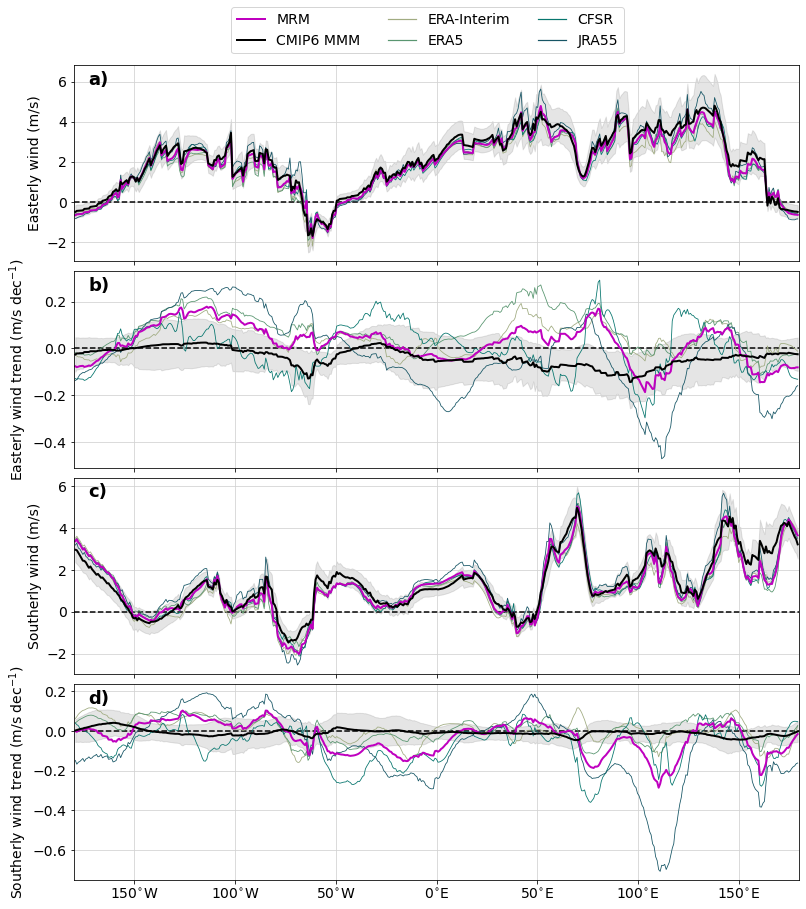

In [33]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (13, 15))
gr = gs.GridSpec(4, 1, figure = fig, hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[3,0])]
for ax, label in zip(axs, ['a)', 'b)', 'c)', 'd)']):
    ax.text(0.02, .9, label, transform = ax.transAxes, size = 18, weight = 'bold')
    ax.grid(linestyle = '-', color = 'lightgrey')
    ax.axhline(y = 0, linestyle = '--', color = 'k')
    ax.set_xlim(-180, 180)
    ax.set_xticks(np.arange(-150, 200, 50))
    if ax == axs[-1]:
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    else:
        ax.set_xticklabels([])
axs[0].set_ylabel('Easterly wind (m/s)')
axs[1].set_ylabel('Easterly wind trend (m/s dec$^{-1}$)')
axs[2].set_ylabel('Southerly wind (m/s)')
axs[3].set_ylabel('Southerly wind trend (m/s dec$^{-1}$)')

# Zonal
for k, cl in zip(keys[:-1], [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76)]):
    axs[0].plot(u_ave[k]['lon'], -u_ave[k], color = cl, linewidth = .8)
    axs[1].plot(ut_ave[k]['lon'], -10*ut_ave[k], color = cl, linewidth = .8)
axs[0].plot(u_ave['reanalysis']['lon'], -u_ave['reanalysis'], color = 'm', linewidth = 2)
axs[0].plot(u_ave['cmip6']['lon'], -u_ave['cmip6'], color = 'k', linewidth = 2)
axs[0].fill_between(u_ave['cmip6']['lon'], -u_ave['cmip6']+u_ave_cmip_sd, 
                   -u_ave['cmip6']-u_ave_cmip_sd, color = 'k', alpha = 0.1)

axs[1].plot(ut_ave['reanalysis']['lon'], -10*ut_ave['reanalysis'], color = 'm', linewidth = 2)
axs[1].plot(ut_ave['cmip6']['lon'], -10*ut_ave['cmip6'], color = 'k', linewidth = 2)
axs[1].fill_between(ut_ave['cmip6']['lon'], -10*(ut_ave['cmip6']+ut_ave_cmip_sd), 
                   -10*(ut_ave['cmip6']-ut_ave_cmip_sd), color = 'k', alpha = 0.1)

# Meridional
for k, cl in zip(keys[:-1], [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76)]):
    axs[2].plot(v_ave[k]['lon'], v_ave[k], color = cl, linewidth = .8)
    axs[3].plot(vt_ave[k]['lon'], 10*vt_ave[k], color = cl, linewidth = .8)
axs[2].plot(v_ave['reanalysis']['lon'], v_ave['reanalysis'], color = 'm', linewidth = 2)
axs[2].plot(v_ave['reanalysis']['lon'], v_ave['cmip6'], color = 'k', linewidth = 2)
axs[2].fill_between(v_ave['cmip6']['lon'], v_ave['cmip6']-v_ave_cmip_sd, 
                    v_ave['cmip6']+v_ave_cmip_sd, color = 'k', alpha = 0.1)
axs[3].plot(vt_ave['reanalysis']['lon'], 10*vt_ave['reanalysis'], color = 'm', linewidth = 2)
axs[3].plot(vt_ave['cmip6']['lon'], 10*vt_ave['cmip6'], color = 'k', linewidth = 2)
axs[3].fill_between(vt_ave['cmip6']['lon'], 10*(vt_ave['cmip6']-vt_ave_cmip_sd), 
                    10*(vt_ave['cmip6']+vt_ave_cmip_sd), color = 'k', alpha = 0.1)

fig.legend(handles = legend_elements, ncol = 3, bbox_to_anchor = (.72, .94))

plt.savefig('../results/v6/fig2.jpg', bbox_inches = 'tight')